<a href="https://colab.research.google.com/github/chmelma6/Python-BE-API-Lesson/blob/main/100_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predikce cévní mozkové příhody




Cílem této práce je vyvinout model strojového učení schopný identifikovat pacienty s vysokým rizikem cévní mozkové příhody (mrtvice) na základě jejich klinických a demografických údajů.





## Načtení knihoven a dat

### Dataset

Pro trénování modelu byla použita datová sada Healthcare Dataset Stroke Data (zdroj: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

Tento dataset obsahuje záznamy o 5110 pacientech s celkem 11 vstupními atributy:
- Identifikační údaj (id)
- Pohlaví (gender)
- Věk (age)
- Vysoký krevní tlak (hypertension)
- Onemocnění srdce (heart_disease)
- Manželství (ever_married)
- Typ zaměstnání (work_type)
- Typ bydliště (Residence_type)
- Hladina glukózy v krvi (avg_glucose_level)
- BMI index (bmi)
- Kuřák / nekuřák (smoking_status)

a jedním výstupním atributem, zda pacient prodělal mrtvici (stroke).


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler


# Načtení dat
try:
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')
    print(f"Dataset načten. Rozměry: {df.shape}")
except FileNotFoundError:
    print("Chyba: Soubor nebyl nalezen.")





Dataset načten. Rozměry: (5110, 12)


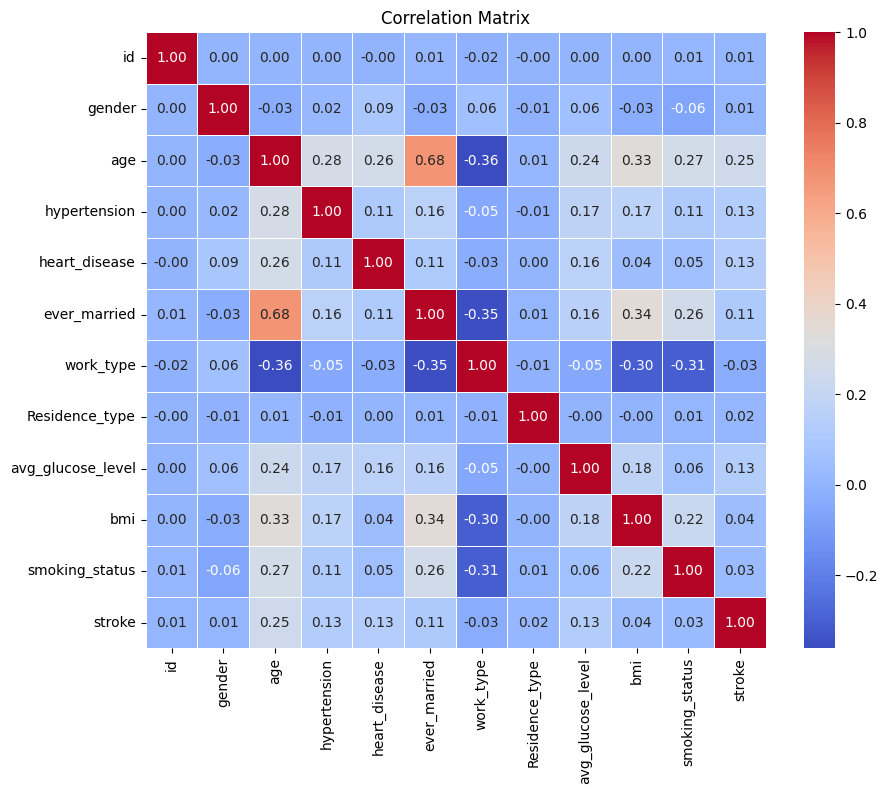

In [140]:
#Vytvoříme si kopii datasetu
df_corr = df.copy()

# Převedeme textové sloupce na čísla
le = LabelEncoder()
textove_sloupce = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in textove_sloupce:
    if col in df_corr.columns:
        df_corr[col] = le.fit_transform(df_corr[col])

# Vypočítá korelaci
correlation_matrix = df_corr.corr()

# Vykreslení gmatice
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",        # 2 desetinná místa
            cmap='coolwarm',
            linewidths=0.5)

plt.title('Correlation Matrix')
plt.show()

Z matice korelace mezi jednotlivými příznaky je vidět, že největší lineární závislost mrtvice s věkem (0.25). Naopak je nízka lineární závislost BMI indexu s mrtvicí (jen 0.04).

#Analýza datasetu


 Provedena kontrola chybějících dat a potvrzení ojedinělého vyskytnutí pohlaví 'Other', které by mohlo způsobovat šum.

In [141]:
# Kontrola chybějcích dat
print("\nChybějící hodnoty:")
print(df.isnull().sum(),"\n")


print("\nRozdělení gender hodnoty:")
gender_counts = df['gender'].value_counts()
print(gender_counts)



Chybějící hodnoty:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64 


Rozdělení gender hodnoty:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


Vizualizace rozdělení počtu lidí, kteří prodělali mrtvici a zdravých lidí.

<Figure size 1000x1000 with 0 Axes>

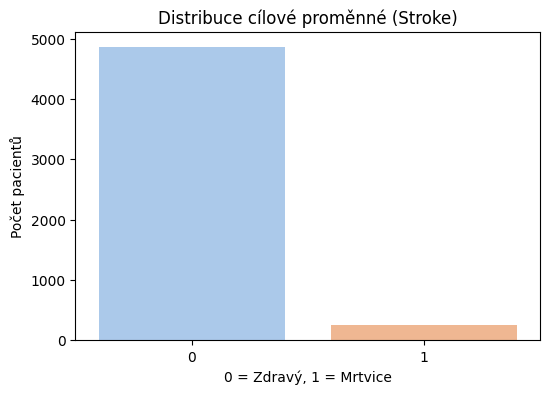


Rozdělení výstupní hodnoty:
stroke
0    4861
1     249
Name: count, dtype: int64


In [142]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Kontrola nevyváženosti tříd
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=df, hue='stroke', legend=False, palette='pastel')
plt.title('Distribuce cílové proměnné (Stroke)')
plt.xlabel('0 = Zdravý, 1 = Mrtvice')
plt.ylabel('Počet pacientů')
plt.show()

print("\nRozdělení výstupní hodnoty:")
stroke_counts = df['stroke'].value_counts()
print(stroke_counts)


##Kontrola a příprava data setu

### Příprava dat
V této fázi byl dataset podroben sérii kroků pro zajištění kvality a použitelnosti dat pro strojové učení:

1. Odstranění sloupce id (nenese prediktivní informaci).
2. Odstranění ojedinělého záznamu pohlaví "Other".
2. Chybějící hodnoty BMI jsou nahrazeny průměrem specifickým pro věkovou skupinu daného pacienta, což je přesnější než globální průměr.
3. Textové údaje byly převedeny na číselné hodnoty, která vytváří pro každou kategorii samostatný sloupec s hodnotami 0 a 1.
4. Data byla rozdělena na trénovací a testovací v poměru 80:20.
5. Vzhledem k silné nevyváženosti tříd (nízký počet případů mrtvice) byla na trénovací data aplikována metoda Random OverSampling. Tato metoda náhodně duplikuje záznamy menšinové třídy (pacienti s mrtvicí), dokud není dosaženo rovnoměrného zastoupení obou tříd. Tím se zabránilo tomu, aby model preferoval majoritní třídu.


Po oversamplingu:
stroke
0    3889
1    3889
Name: count, dtype: int64


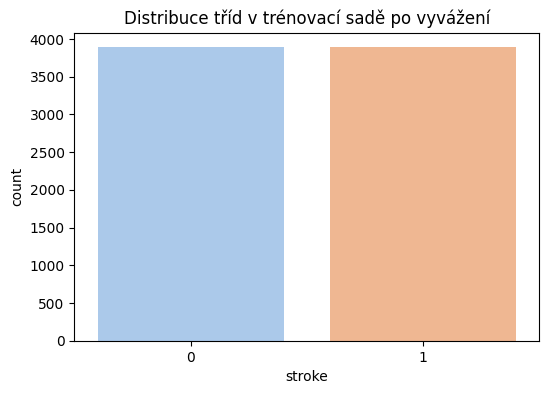


Data jsou vyčištěna a připravena.


In [143]:
# 1. Odstranění ID
if 'id' in df.columns:
    df = df.drop('id', axis=1)

# 2. Odstranění 'Other'
df=df.drop(df[df['gender']=='Other'].index)

# 3. Doplnění chybějících hodnot BMI
# Vypočítáme průměrné BMI pro každý věk
avg_bmi_by_age = df.groupby('age')['bmi'].mean()
#print(avg_bmi_by_age)

def replace_bmi(row):
  if pd.isna(row['bmi']):
    return avg_bmi_by_age[row['age']]
  else:
    return row ['bmi']

df['bmi']=df.apply(replace_bmi, axis=1)

# 4. Převedení slov na čísla
df_encoded = pd.get_dummies(df, drop_first=True)

# Definice vstupu (X) a výstupu (y)
X = df_encoded.drop('stroke', axis=1) # odstraní sloupec stroke ostatní uloží do X
y = df_encoded['stroke'] # do y se uloží sloupec stroke

# 5. Rozdělení dat na trénovací a testovací sady
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1234)

# 6. Vyvážení trénovacích dat (Random OverSampling)
ros = RandomOverSampler(random_state=1234)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("\nPo oversamplingu:")
print(y_train_ros.value_counts())

# Vizualizace po vyvážení
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_ros, hue=y_train_ros, legend=False,  palette='pastel')
plt.title('Distribuce tříd v trénovací sadě po vyvážení')
plt.show()


print("\nData jsou vyčištěna a připravena.")

### Metoda Random Forest



Pro klasifikaci byl zvolen Random Forest Classifier.
Oproti jednoduchému rozhodovacímu stromu (Decision Tree), který je náchylný k přeučení, Random Forest vytváří "les" mnoha nezávislých stromů a jejich výsledky kombinuje.

Je vhodný pro lékařské záznamy, protože dobře pracuje s tabulkovými daty a zvládá nelineární vztahy mezi lékařskými faktory (věk, BMI, kouření).

Díky průměrování výsledků z mnoha stromů redukuje šum a je stabilnější než jeden rozhodovací strom.

Navíc identifikuje, které proměnné mají největší váhu při rozhodování.

In [144]:
# Definice modelu Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,       # Počet strom 200
    max_depth=10,            # Maximální hloubka stromu (prevence přeučení)
    random_state=1234,
)

print("Model Random Forest je definován.")

Model Random Forest je definován.


### Trénování klasifikátoru a predikce na testovacích datech

Accuracy: 0.8836
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       971
           1       0.15      0.29      0.20        51

    accuracy                           0.88      1022
   macro avg       0.56      0.60      0.57      1022
weighted avg       0.92      0.88      0.90      1022



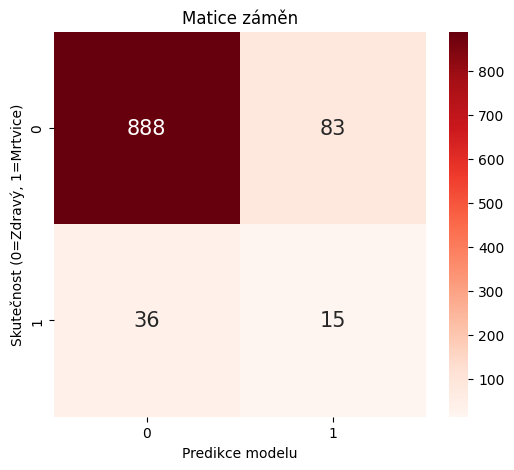

In [145]:
# Trénování modelu na vyvážených datech
rf_model.fit(X_train_ros, y_train_ros)

# Predikce na testovacích datech
predictions = rf_model.predict(X_test)

# Výpis přesnosti a detailního reportu
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print("Classification Report")
print(classification_report(y_test, predictions))

# Vizualizace Matice záměn (Confusion Matrix)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={"size": 15})
plt.title(f'Matice záměn')
plt.ylabel('Skutečnost (0=Zdravý, 1=Mrtvice)')
plt.xlabel('Predikce modelu')
plt.show()


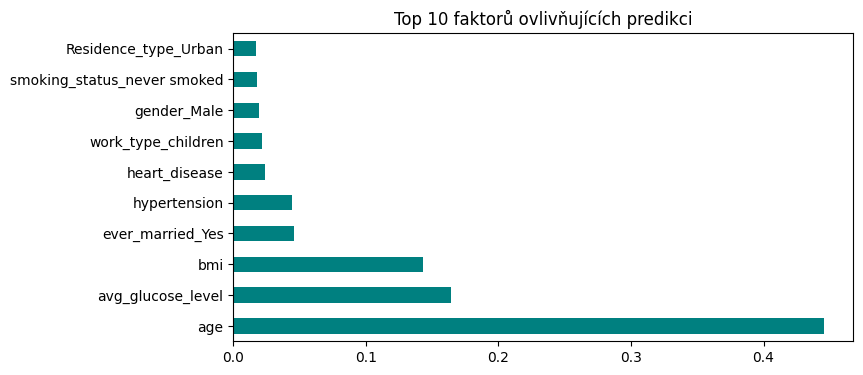

In [146]:
# Graf důležitosti faktorů pro rozhodování
plt.figure(figsize=(8, 4))
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Top 10 faktorů ovlivňujících predikci')
plt.show()

## Diskuze

Celková přesnost modelu dosáhla na testovacích datech 88,36 %.

Z analýzy Matice záměn vyplývá, že model správně klasifikoval 888 zdravých jedinců a úspěšně odhalil 15 rizikových pacientů.

Zároveň detekoval 83 falešných poplachů a neodhalil 36 případů.

Klíčovým prvkem bylo použití metody Random OverSampling, která umožnila modelu zaměřit se na menšinovou třídu a dosáhnout senzitivity (Recall) přibližně 29 %, zatímco bez vyvážení by model rizikové pacienty ignoroval. Tento vyšší záchyt je však vykoupen nižší přesností (Precision 15 %), což znamená častější falešná varování.

Z graf důležitosti faktorů lze vidět, že model identifikoval jako nejvýznamnější prediktory podle kterých rozhodoval  věk, hladinu glukózy a BMI index.